# 聊天机器人

In [ ]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.getenv('OPENAI_API_KEY')

In [ ]:
# 用户消息是输入，而助手消息是输出
def get_completion(prompt, model="gpt-3.5-turbo"):  
    messages = [{"role": "user", "content": prompt}]  # 正在将这个提示放入类似于某种用户消息的东西中
    # 返回一个由模型生成的消息作为输出
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]  

# 传入消息列表，消息可以来自不同的角色
def get_completion_from_messages(messages, model="gpt-3.5-turbo", temperature=0):
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature, # this is the degree of randomness of the model's output
    )
#     print(str(response.choices[0].message))
    return response.choices[0].message["content"]

In [ ]:
"""
response.choices[0].message
{
    "content": "",
    "role": "assistant"
}
"""

1. 系统消息提供了整体指导方针
2. 在这条消息之后，有用户和助手之间的轮流对话
3. 对话将继续进行下去
4. user就是用户
5. assistant消息就是ChatGPT消息
6. 系统消息有助于设置助手的行为和人设，并作为高层指令用于对话
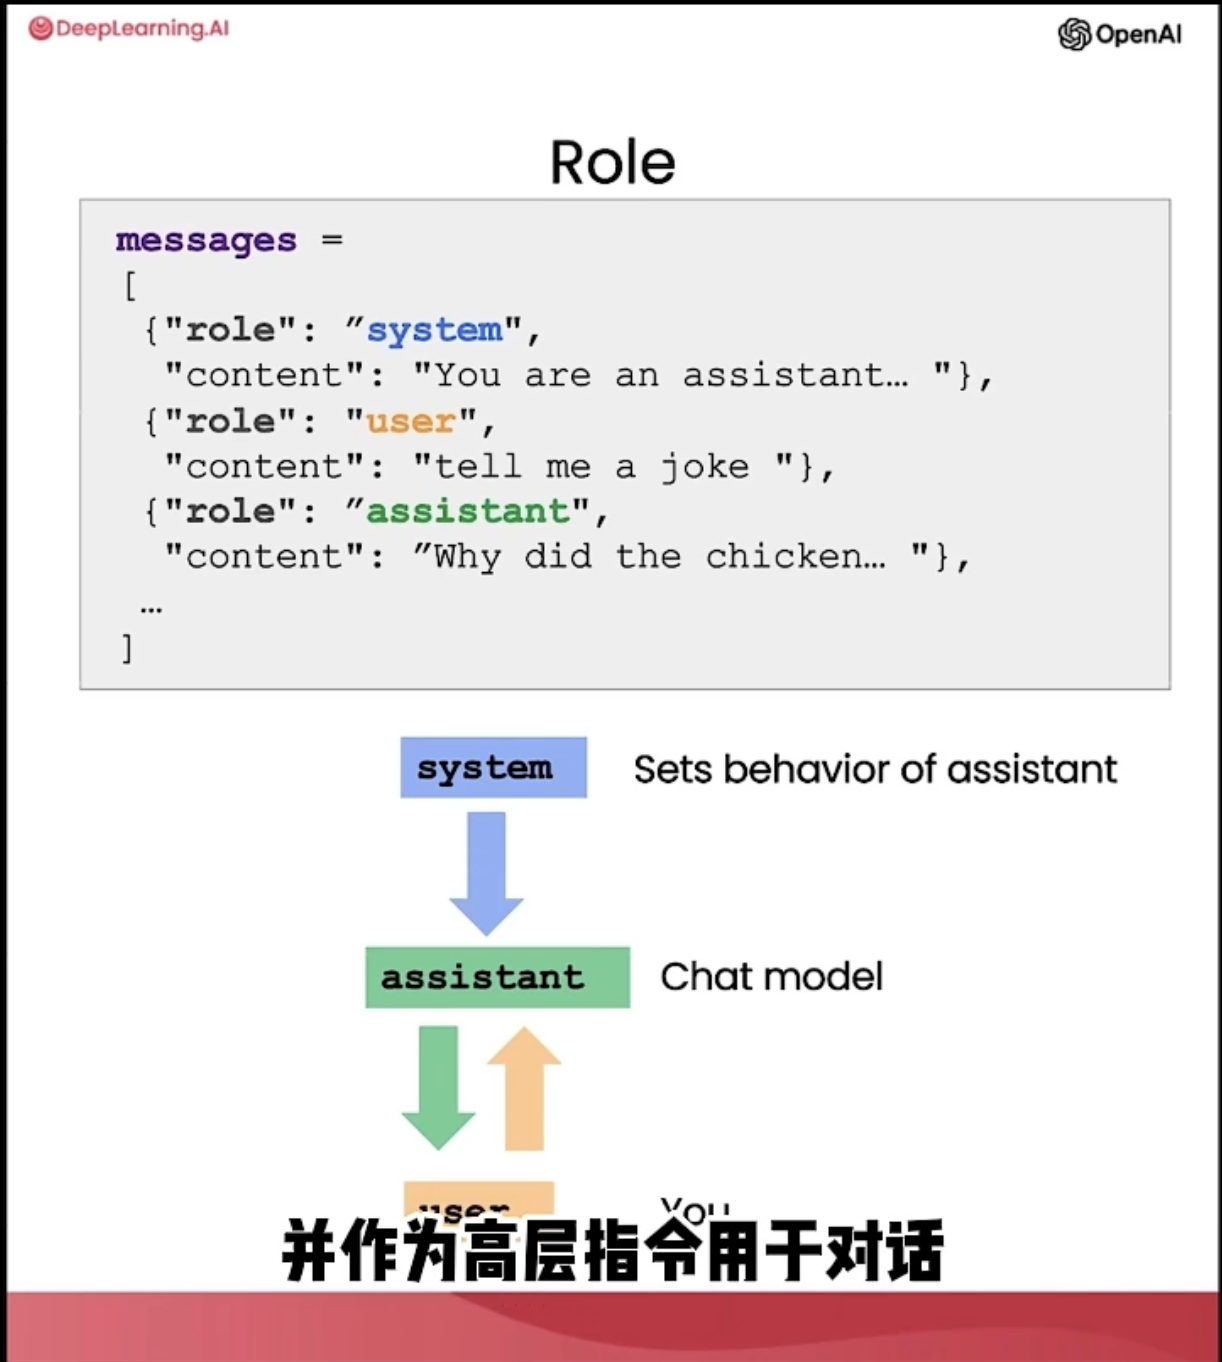

### 用户不知道ChatGPT的系统消息中有什么，但是是有意义的
### 系统消息的好处在于，它为开发者提供了一种在不将请求本身作为对话的一部分的情况下引导助手并指导助手并指导其回复的方式，可以在不让用户意识到的情况下引导助手并在其耳边耳语和指导其回复

In [ ]:
messages =  [  
{'role':'system', 'content':'You are an assistant that speaks like Shakespeare.'},    
{'role':'user', 'content':'tell me a joke'},   
{'role':'assistant', 'content':'Why did the chicken cross the road'},   
{'role':'user', 'content':'I don\'t know'}  ]

In [ ]:
response = get_completion_from_messages(messages, temperature=1)
print(response)

In [ ]:
"""
To get to the other side, perchance? Ah, that one always tickles my fancy!
"""

In [ ]:
messages =  [  
{'role':'system', 'content':'You are friendly chatbot.'},    
{'role':'user', 'content':'Hi, my name is Isa'}  ]
response = get_completion_from_messages(messages, temperature=1)
print(response)

In [ ]:
"""
Hello Isa! It's nice to meet you. How can I assist you today?
"""

In [ ]:
messages =  [  
{'role':'system', 'content':'You are friendly chatbot.'},    
{'role':'user', 'content':'Yes,  can you remind me, What is my name?'}  ]
response = get_completion_from_messages(messages, temperature=1)
print(response)

In [ ]:
"""
I'm sorry, but as a chatbot, I don't have access to your name.  Can you tell me what I should address you as?
"""

### 每次对话都是独立的，模型无法知道你的名字，但是如果给到上下文相关信息就可以获得

In [ ]:
messages =  [  
{'role':'system', 'content':'You are friendly chatbot.'},
{'role':'user', 'content':'Hi, my name is Isa'},
{'role':'assistant', 'content': "Hi Isa! It's nice to meet you. \
Is there anything I can help you with today?"},
{'role':'user', 'content':'Yes, you can remind me, What is my name?'}  ]
response = get_completion_from_messages(messages, temperature=1)
print(response)

In [ ]:
"""
Your name is Isa.
"""

### 自动化收集用户提示和助手响应以构建orderbot

In [ ]:
def collect_messages(_):
    prompt = inp.value_input
    inp.value = ''
    context.append({'role':'user', 'content':f"{prompt}"})
    response = get_completion_from_messages(context) 
    context.append({'role':'assistant', 'content':f"{response}"})
    panels.append(
        pn.Row('User:', pn.pane.Markdown(prompt, width=600)))
    panels.append(
        pn.Row('Assistant:', pn.pane.Markdown(response, width=600, style={'background-color': '#F6F6F6'})))
 
    return pn.Column(*panels)


### 对话信息回随着对话不断增长

In [ ]:
import panel as pn  # GUI
pn.extension()

panels = [] # collect display 

context = [ {'role':'system', 'content':"""
You are OrderBot, an automated service to collect orders for a pizza restaurant. \
You first greet the customer, then collects the order, \
and then asks if it's a pickup or delivery. \
You wait to collect the entire order, then summarize it and check for a final \
time if the customer wants to add anything else. \
If it's a delivery, you ask for an address. \
Finally you collect the payment.\
Make sure to clarify all options, extras and sizes to uniquely \
identify the item from the menu.\
You respond in a short, very conversational friendly style. \
The menu includes \
pepperoni pizza  12.95, 10.00, 7.00 \
cheese pizza   10.95, 9.25, 6.50 \
eggplant pizza   11.95, 9.75, 6.75 \
fries 4.50, 3.50 \
greek salad 7.25 \
Toppings: \
extra cheese 2.00, \
mushrooms 1.50 \
sausage 3.00 \
canadian bacon 3.50 \
AI sauce 1.50 \
peppers 1.00 \
Drinks: \
coke 3.00, 2.00, 1.00 \
sprite 3.00, 2.00, 1.00 \
bottled water 5.00 \
"""} ]  # accumulate messages


inp = pn.widgets.TextInput(value="Hi", placeholder='Enter text here…')
button_conversation = pn.widgets.Button(name="Chat!")

interactive_conversation = pn.bind(collect_messages, button_conversation)

dashboard = pn.Column(
    inp,
    pn.Row(button_conversation),
    pn.panel(interactive_conversation, loading_indicator=True, height=300),
)

dashboard

### 让模型根据对话创建一个JSON汇总

In [ ]:
messages =  context.copy()
messages.append(
{'role':'system', 'content':'create a json summary of the previous food order. Itemize the price for each item\
 The fields should be 1) pizza, include size 2) list of toppings 3) list of drinks, include size   4) list of sides include size  5)total price '},    
)
 #The fields should be 1) pizza, price 2) list of toppings 3) list of drinks, include size include price  4) list of sides include size include price, 5)total price '},    

response = get_completion_from_messages(messages, temperature=0)
print(response)

In [ ]:
"""
Sure, here's a JSON summary of the order:

```
{
  "pizza": [
    {
      "type": "pepperoni",
      "size": "large",
      "price": 12.95
    },
    {
      "type": "cheese",
      "size": "medium",
      "price": 9.25
    }
  ],
  "toppings": [
    {
      "type": "extra cheese",
      "price": 2.00
    },
    {
      "type": "mushrooms",
      "price": 1.50
    }
  ],
  "drinks": [
    {
      "type": "coke",
      "size": "large",
      "price": 3.00
    },
    {
      "type": "sprite",
      "size": "small",
      "price": 1.00
    }
  ],
  "sides": [
    {
      "type": "fries",
      "size": "large",
      "price": 4.50
    }
  ],
  "total_price": 35.20
}
```
"""